In [10]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
from os import path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

In [3]:
df = pd.read_csv(r"./Data/"+"hchs_quest_pa_one_hot.csv")

In [4]:
#Base for regression pipeline, this time with 'real' data extracted earlier in the notebook
#print(df.head(5))
#I've left out most of the PA columns as the are highly correlated
df_nan = df[['SleepEfficiency', 'Awakening', 'TotalSleepTime',
       'TotalWakeTime', 'SRIDay', 'SRISleep', 'mvpa_bouts_1min_decomp',
        'mvpa_bouts_10min_decomp', 'vpa_bouts_1min_decomp', 'gender', 'age', 'bmi', 'cafe', 'tea',
       'cancer', 'ssleepd', 'epworth', 'whiirs', 'insomnia_sev', 'insomnia_sev_grp_2.0',
       'insomnia_sev_grp_3.0', 'insomnia_sev_grp_4.0', 'alcohol_2.0',
       'alcohol_3.0', 'cigar_2.0', 'cigar_3.0', 'cafe_wake_1', 'cafe_wake_2',
       'cafe_wake_3', 'cafe_wake_4', 'employ_2.0', 'employ_3.0', 'employ_4.0',
       'diabetes_2.0', 'diabetes_3.0', 'persontype_1', 'persontype_2',
       'persontype_3', 'persontype_4']]

sleep_features = ['SleepEfficiency', 'Awakening', 'TotalSleepTime',
       'TotalWakeTime', 'SRIDay', 'SRISleep']

scaler = StandardScaler()
df_zipped = pd.DataFrame(scaler.fit_transform(df_nan), columns = df_nan.columns).dropna()

Index(['mvpa_bouts_1min_decomp', 'bmi', 'cafe', 'ssleepd', 'epworth',
       'insomnia_sev', 'insomnia_sev_grp_3.0', 'diabetes_3.0'],
      dtype='object')
{'mvpa_bouts_1min_decomp': 1, 'mvpa_bouts_10min_decomp': 3, 'vpa_bouts_1min_decomp': 23, 'gender': 2, 'age': 15, 'bmi': 1, 'cafe': 1, 'tea': 25, 'cancer': 8, 'ssleepd': 1, 'epworth': 1, 'whiirs': 20, 'insomnia_sev': 1, 'insomnia_sev_grp_2.0': 18, 'insomnia_sev_grp_3.0': 1, 'insomnia_sev_grp_4.0': 26, 'alcohol_2.0': 22, 'alcohol_3.0': 10, 'cigar_2.0': 14, 'cigar_3.0': 19, 'cafe_wake_1': 12, 'cafe_wake_2': 9, 'cafe_wake_3': 11, 'cafe_wake_4': 24, 'employ_2.0': 17, 'employ_3.0': 13, 'employ_4.0': 16, 'diabetes_2.0': 21, 'diabetes_3.0': 1, 'persontype_1': 6, 'persontype_2': 7, 'persontype_3': 5, 'persontype_4': 4}
[-0.19052994 -0.10811527 -0.09883402  0.21359548 -0.16376769  0.16616776
 -0.10401364  0.12098307]
train_score: 0.19258021747974108
test_score: 0.12548090763921083
                        0         1
0  mvpa_bouts_1min_decomp 

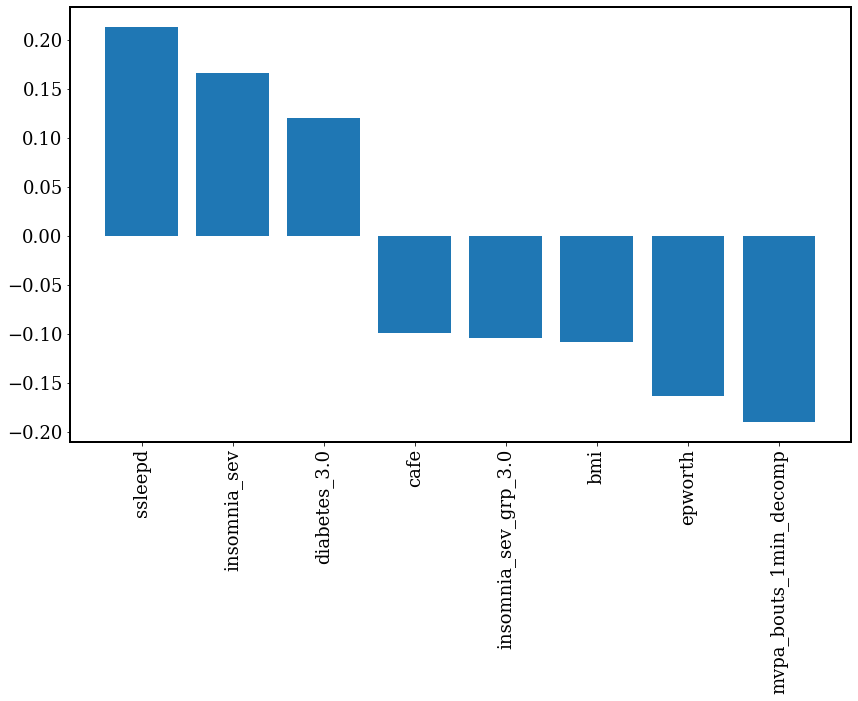

                                 OLS Regression Results                                
Dep. Variable:         TotalSleepTime   R-squared (uncentered):                   0.192
Model:                            OLS   Adj. R-squared (uncentered):              0.183
Method:                 Least Squares   F-statistic:                              20.60
Date:                Fri, 19 Jun 2020   Prob (F-statistic):                    4.05e-28
Time:                        13:39:10   Log-Likelihood:                         -884.64
No. Observations:                 701   AIC:                                      1785.
Df Residuals:                     693   BIC:                                      1822.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [5]:
#Recursive Feature Elimination 1
col1 = 'TotalSleepTime'
X_col1 = df_zipped.drop(sleep_features,axis=1)
y_col1 = df_zipped[col1]

X_train,X_test,y_train,y_test=train_test_split(X_col1,y_col1, test_size=0.3, random_state=123)

rfe1 = RFE(estimator=LinearRegression(), n_features_to_select=8, verbose=0)
model_rfe_1 = rfe1.fit(X_train, y_train)

print(X_train.columns[rfe1.support_])
print(dict(zip(X_train.columns, rfe1.ranking_)))
print(rfe1.estimator_.coef_)
print('train_score:',rfe1.score(X_train,y_train))
print('test_score:',rfe1.score(X_test,y_test))

# negate the coeff. to sort them in descending order
selected = pd.DataFrame(zip(X_train.columns[rfe1.support_], rfe1.estimator_.coef_))
print(selected)
sorting = selected.sort_values(1,ascending=False)
print(sorting)

plt.bar(sorting[0], sorting[1])
plt.xticks(rotation=90)
plt.show()

mask = X_train.columns[rfe1.support_]
X_col1 = sm.add_constant(X_col1)
model_col1_sm = sm.OLS(y_train, X_train[mask]).fit() ## sm.OLS(output, input)
predictions = model_col1_sm.predict(X_test[mask])

# Print out the statistics
print(model_col1_sm.summary())

Index(['mvpa_bouts_1min_decomp', 'gender', 'age', 'bmi', 'ssleepd', 'epworth',
       'whiirs', 'insomnia_sev'],
      dtype='object')
{'mvpa_bouts_1min_decomp': 1, 'mvpa_bouts_10min_decomp': 15, 'vpa_bouts_1min_decomp': 4, 'gender': 1, 'age': 1, 'bmi': 1, 'cafe': 2, 'tea': 18, 'cancer': 5, 'ssleepd': 1, 'epworth': 1, 'whiirs': 1, 'insomnia_sev': 1, 'insomnia_sev_grp_2.0': 20, 'insomnia_sev_grp_3.0': 14, 'insomnia_sev_grp_4.0': 17, 'alcohol_2.0': 22, 'alcohol_3.0': 12, 'cigar_2.0': 16, 'cigar_3.0': 3, 'cafe_wake_1': 7, 'cafe_wake_2': 24, 'cafe_wake_3': 8, 'cafe_wake_4': 10, 'employ_2.0': 11, 'employ_3.0': 19, 'employ_4.0': 13, 'diabetes_2.0': 9, 'diabetes_3.0': 6, 'persontype_1': 21, 'persontype_2': 23, 'persontype_3': 25, 'persontype_4': 26}
[0.28344526 0.03522007 0.06950787 0.19209433 0.22106386 0.11106018
 0.04954119 0.03806724]
train_score: 0.4853562857297999
test_score: 0.13062034452874538
                        0         1
0  mvpa_bouts_1min_decomp  0.283445
1                  g

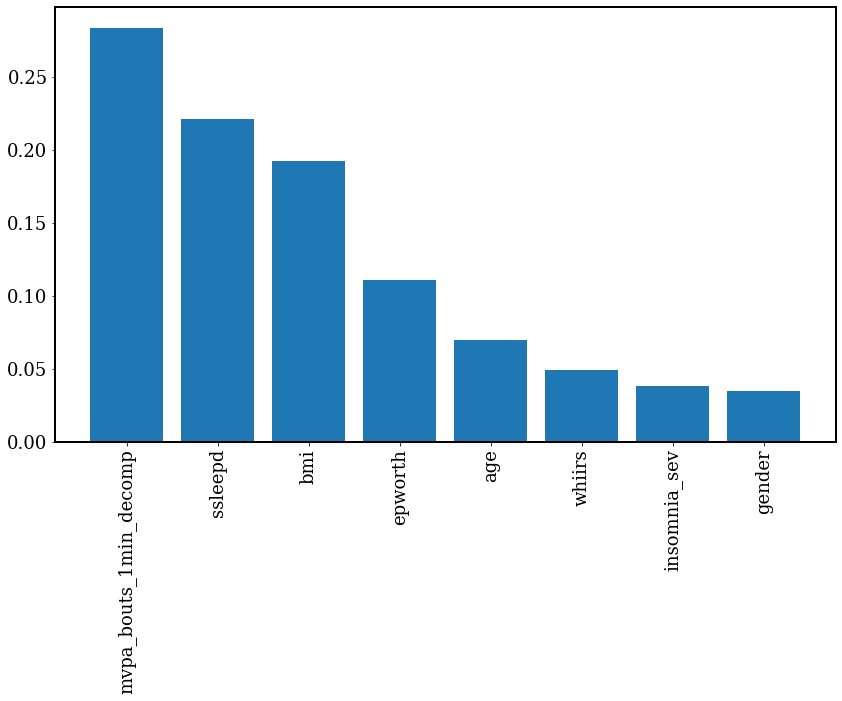

                                 OLS Regression Results                                
Dep. Variable:         TotalSleepTime   R-squared (uncentered):                   0.168
Model:                            OLS   Adj. R-squared (uncentered):              0.158
Method:                 Least Squares   F-statistic:                              17.48
Date:                Fri, 19 Jun 2020   Prob (F-statistic):                    7.74e-24
Time:                        13:53:12   Log-Likelihood:                         -895.02
No. Observations:                 701   AIC:                                      1806.
Df Residuals:                     693   BIC:                                      1842.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [16]:
#Recursive Feature Elimination 1
col1 = 'TotalSleepTime'
X_col1 = df_zipped.drop(sleep_features,axis=1)
y_col1 = df_zipped[col1]

X_train,X_test,y_train,y_test=train_test_split(X_col1,y_col1, test_size=0.3, random_state=123)

rfe1 = RFE(estimator=GradientBoostingRegressor(random_state=0,n_estimators=100,learning_rate=0.05), n_features_to_select=8, verbose=0)
model_rfe_1 = rfe1.fit(X_train, y_train)

print(X_train.columns[rfe1.support_])
print(dict(zip(X_train.columns, rfe1.ranking_)))
print(rfe1.estimator_.feature_importances_)
print('train_score:',rfe1.score(X_train,y_train))
print('test_score:',rfe1.score(X_test,y_test))

# negate the coeff. to sort them in descending order
selected = pd.DataFrame(zip(X_train.columns[rfe1.support_], rfe1.estimator_.feature_importances_))
print(selected)
sorting = selected.sort_values(1,ascending=False)
print(sorting)

plt.bar(sorting[0], sorting[1])
plt.xticks(rotation=90)
plt.show()

mask = X_train.columns[rfe1.support_]
X_col1 = sm.add_constant(X_col1)
model_col1_sm = sm.OLS(y_train, X_train[mask]).fit() ## sm.OLS(output, input)
predictions = model_col1_sm.predict(X_test[mask])

# Print out the statistics
print(model_col1_sm.summary())

Index(['mvpa_bouts_1min_decomp', 'gender', 'whiirs', 'insomnia_sev',
       'insomnia_sev_grp_2.0', 'insomnia_sev_grp_3.0', 'insomnia_sev_grp_4.0',
       'cigar_3.0'],
      dtype='object')
{'mvpa_bouts_1min_decomp': 1, 'mvpa_bouts_10min_decomp': 2, 'vpa_bouts_1min_decomp': 24, 'gender': 1, 'age': 12, 'bmi': 7, 'cafe': 8, 'tea': 25, 'cancer': 14, 'ssleepd': 13, 'epworth': 9, 'whiirs': 1, 'insomnia_sev': 1, 'insomnia_sev_grp_2.0': 1, 'insomnia_sev_grp_3.0': 1, 'insomnia_sev_grp_4.0': 1, 'alcohol_2.0': 10, 'alcohol_3.0': 11, 'cigar_2.0': 21, 'cigar_3.0': 1, 'cafe_wake_1': 20, 'cafe_wake_2': 26, 'cafe_wake_3': 23, 'cafe_wake_4': 15, 'employ_2.0': 5, 'employ_3.0': 4, 'employ_4.0': 3, 'diabetes_2.0': 6, 'diabetes_3.0': 22, 'persontype_1': 18, 'persontype_2': 17, 'persontype_3': 19, 'persontype_4': 16}
[-0.12475825 -0.18250937 -0.15476425  0.23606988 -0.15038023 -0.23864751
 -0.15462482 -0.1283198 ]
train_score: 0.1050440868889011
test_score: 0.09428868163171145
                        0   

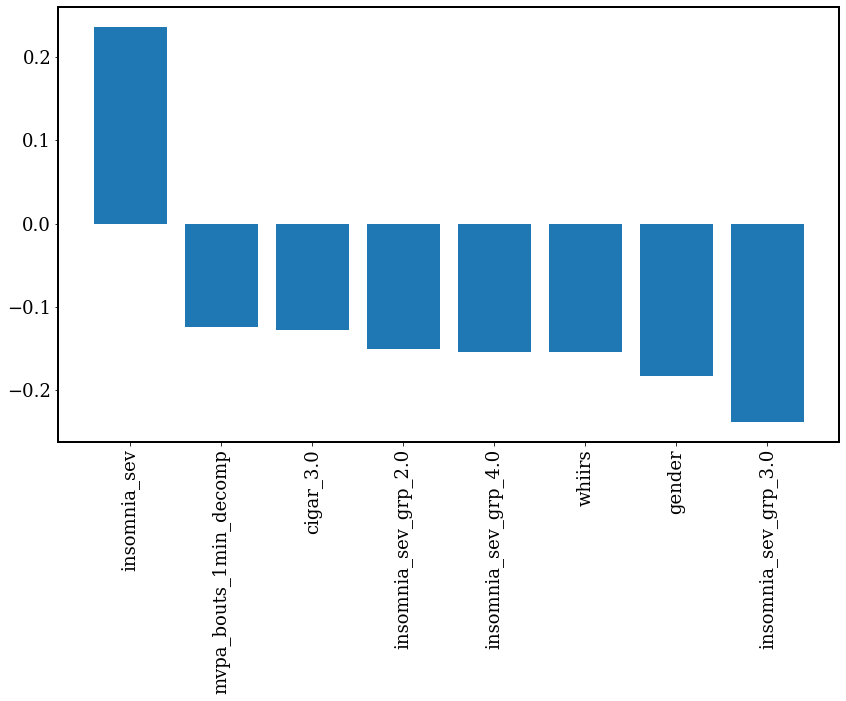

                                 OLS Regression Results                                
Dep. Variable:        SleepEfficiency   R-squared (uncentered):                   0.105
Model:                            OLS   Adj. R-squared (uncentered):              0.095
Method:                 Least Squares   F-statistic:                              10.17
Date:                Fri, 19 Jun 2020   Prob (F-statistic):                    1.76e-13
Time:                        13:39:44   Log-Likelihood:                         -939.46
No. Observations:                 701   AIC:                                      1895.
Df Residuals:                     693   BIC:                                      1931.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [6]:
#Recursive Feature Elimination 1
col2 = 'SleepEfficiency'
X_col2 = df_zipped.drop(sleep_features,axis=1)
y_col2 = df_zipped[col2]

X_train,X_test,y_train,y_test=train_test_split(X_col2,y_col2, test_size=0.3, random_state=123)

rfe2 = RFE(estimator=LinearRegression(), n_features_to_select=8, verbose=0)
model_rfe_2 = rfe2.fit(X_train, y_train)

print(X_train.columns[rfe2.support_])
print(dict(zip(X_train.columns, rfe2.ranking_)))
print(rfe2.estimator_.coef_)
print('train_score:',rfe2.score(X_train,y_train))
print('test_score:',rfe2.score(X_test,y_test))

# negate the coeff. to sort them in descending order
selected2 = pd.DataFrame(zip(X_train.columns[rfe2.support_], rfe2.estimator_.coef_))
print(selected2)
sorting2 = selected2.sort_values(1,ascending=False)
print(sorting2)

plt.bar(sorting2[0], sorting2[1])
plt.xticks(rotation=90)
plt.show()

mask2 = X_train.columns[rfe2.support_]
X_col2 = sm.add_constant(X_col2)
model_col2_sm = sm.OLS(y_train, X_train[mask2]).fit() ## sm.OLS(output, input)
predictions = model_col2_sm.predict(X_test[mask2])

# Print out the statistics
print(model_col2_sm.summary())

Index(['mvpa_bouts_1min_decomp', 'vpa_bouts_1min_decomp', 'gender', 'bmi',
       'ssleepd', 'epworth', 'whiirs', 'insomnia_sev'],
      dtype='object')
{'mvpa_bouts_1min_decomp': 1, 'mvpa_bouts_10min_decomp': 7, 'vpa_bouts_1min_decomp': 1, 'gender': 1, 'age': 3, 'bmi': 1, 'cafe': 4, 'tea': 15, 'cancer': 18, 'ssleepd': 1, 'epworth': 1, 'whiirs': 1, 'insomnia_sev': 1, 'insomnia_sev_grp_2.0': 20, 'insomnia_sev_grp_3.0': 23, 'insomnia_sev_grp_4.0': 25, 'alcohol_2.0': 26, 'alcohol_3.0': 22, 'cigar_2.0': 13, 'cigar_3.0': 2, 'cafe_wake_1': 5, 'cafe_wake_2': 16, 'cafe_wake_3': 8, 'cafe_wake_4': 19, 'employ_2.0': 17, 'employ_3.0': 12, 'employ_4.0': 21, 'diabetes_2.0': 6, 'diabetes_3.0': 10, 'persontype_1': 14, 'persontype_2': 9, 'persontype_3': 11, 'persontype_4': 24}
[0.29251322 0.13115923 0.09817061 0.1546334  0.04808185 0.05438294
 0.06754181 0.15351694]
train_score: 0.3819653688369865
test_score: 0.03230998871001389
                        0         1
0  mvpa_bouts_1min_decomp  0.292513
1 

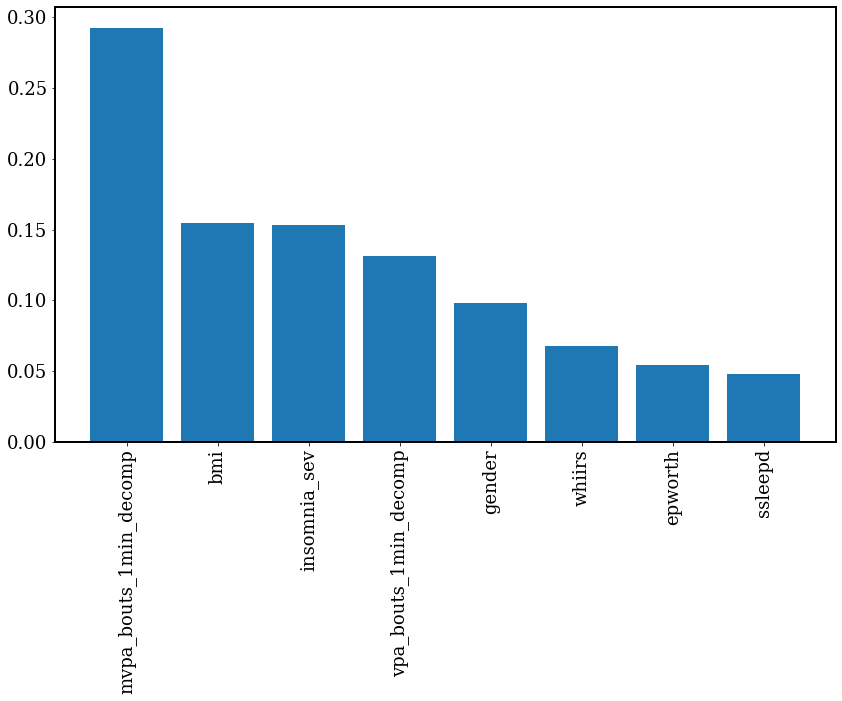

                                 OLS Regression Results                                
Dep. Variable:        SleepEfficiency   R-squared (uncentered):                   0.085
Model:                            OLS   Adj. R-squared (uncentered):              0.074
Method:                 Least Squares   F-statistic:                              8.044
Date:                Fri, 19 Jun 2020   Prob (F-statistic):                    2.06e-10
Time:                        13:56:53   Log-Likelihood:                         -947.23
No. Observations:                 701   AIC:                                      1910.
Df Residuals:                     693   BIC:                                      1947.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [20]:
#Recursive Feature Elimination 1
col2 = 'SleepEfficiency'
X_col2 = df_zipped.drop(sleep_features,axis=1)
y_col2 = df_zipped[col2]

X_train,X_test,y_train,y_test=train_test_split(X_col2,y_col2, test_size=0.3, random_state=123)

rfe2 = RFE(estimator=GradientBoostingRegressor(random_state=0,n_estimators=100, learning_rate=0.02), n_features_to_select=8, verbose=0)
model_rfe_2 = rfe2.fit(X_train, y_train)

print(X_train.columns[rfe2.support_])
print(dict(zip(X_train.columns, rfe2.ranking_)))
print(rfe2.estimator_.feature_importances_)
print('train_score:',rfe2.score(X_train,y_train))
print('test_score:',rfe2.score(X_test,y_test))

# negate the coeff. to sort them in descending order
selected2 = pd.DataFrame(zip(X_train.columns[rfe2.support_], rfe2.estimator_.feature_importances_))
print(selected2)
sorting2 = selected2.sort_values(1,ascending=False)
print(sorting2)

plt.bar(sorting2[0], sorting2[1])
plt.xticks(rotation=90)
plt.show()

mask2 = X_train.columns[rfe2.support_]
X_col2 = sm.add_constant(X_col2)
model_col2_sm = sm.OLS(y_train, X_train[mask2]).fit() ## sm.OLS(output, input)
predictions = model_col2_sm.predict(X_test[mask2])

# Print out the statistics
print(model_col2_sm.summary())

Index(['mvpa_bouts_1min_decomp', 'gender', 'ssleepd', 'epworth', 'cigar_3.0',
       'persontype_1', 'persontype_2', 'persontype_3'],
      dtype='object')
{'mvpa_bouts_1min_decomp': 1, 'mvpa_bouts_10min_decomp': 25, 'vpa_bouts_1min_decomp': 24, 'gender': 1, 'age': 5, 'bmi': 10, 'cafe': 15, 'tea': 26, 'cancer': 9, 'ssleepd': 1, 'epworth': 1, 'whiirs': 22, 'insomnia_sev': 13, 'insomnia_sev_grp_2.0': 14, 'insomnia_sev_grp_3.0': 8, 'insomnia_sev_grp_4.0': 21, 'alcohol_2.0': 18, 'alcohol_3.0': 17, 'cigar_2.0': 12, 'cigar_3.0': 1, 'cafe_wake_1': 23, 'cafe_wake_2': 20, 'cafe_wake_3': 19, 'cafe_wake_4': 11, 'employ_2.0': 4, 'employ_3.0': 3, 'employ_4.0': 2, 'diabetes_2.0': 7, 'diabetes_3.0': 16, 'persontype_1': 1, 'persontype_2': 1, 'persontype_3': 1, 'persontype_4': 6}
[-0.11291833 -0.12927374  0.08391014 -0.09601611 -0.17429759  0.21706585
  0.18823437  0.08345984]
train_score: 0.11241922374395218
test_score: 0.09034285135485876
                        0         1
0  mvpa_bouts_1min_decomp 

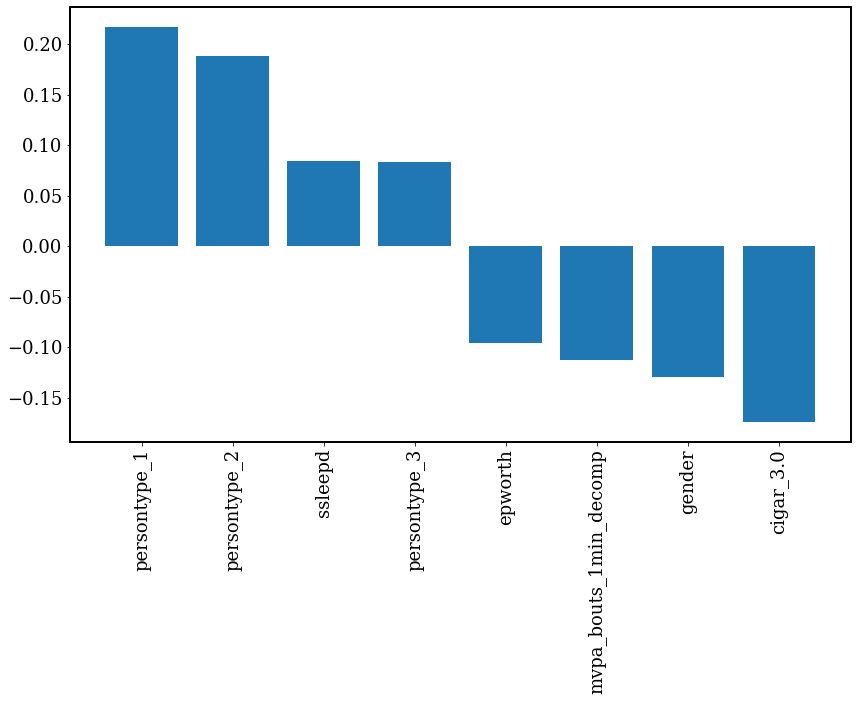

                                 OLS Regression Results                                
Dep. Variable:               SRISleep   R-squared (uncentered):                   0.112
Model:                            OLS   Adj. R-squared (uncentered):              0.102
Method:                 Least Squares   F-statistic:                              10.97
Date:                Fri, 19 Jun 2020   Prob (F-statistic):                    1.22e-14
Time:                        13:40:25   Log-Likelihood:                         -960.56
No. Observations:                 701   AIC:                                      1937.
Df Residuals:                     693   BIC:                                      1974.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [7]:
#Recursive Feature Elimination 3
col3 = 'SRISleep'
X_col3 = df_zipped.drop(sleep_features,axis=1)
y_col3 = df_zipped[col3]

X_train,X_test,y_train,y_test=train_test_split(X_col3,y_col3, test_size=0.3, random_state=123)

rfe3 = RFE(estimator=LinearRegression(), n_features_to_select=8, verbose=0)
model_rfe_3 = rfe3.fit(X_train, y_train)

print(X_train.columns[rfe3.support_])
print(dict(zip(X_train.columns, rfe3.ranking_)))
print(rfe3.estimator_.coef_)
print('train_score:',rfe3.score(X_train,y_train))
print('test_score:',rfe3.score(X_test,y_test))

# negate the coeff. to sort them in descending order
selected3 = pd.DataFrame(zip(X_train.columns[rfe3.support_], rfe3.estimator_.coef_))
print(selected3)
sorting3 = selected3.sort_values(1,ascending=False)
print(sorting3)

plt.bar(sorting3[0], sorting3[1])
plt.xticks(rotation=90)
plt.show()

mask3 = X_train.columns[rfe3.support_]
X_col3 = sm.add_constant(X_col3)
model_col3_sm = sm.OLS(y_train, X_train[mask3]).fit() ## sm.OLS(output, input)
predictions3 = model_col3_sm.predict(X_test[mask3])

# Print out the statistics
print(model_col3_sm.summary())

Index(['gender', 'whiirs', 'insomnia_sev', 'insomnia_sev_grp_2.0',
       'insomnia_sev_grp_3.0', 'insomnia_sev_grp_4.0', 'employ_3.0',
       'employ_4.0'],
      dtype='object')
{'mvpa_bouts_1min_decomp': 6, 'mvpa_bouts_10min_decomp': 5, 'vpa_bouts_1min_decomp': 23, 'gender': 1, 'age': 9, 'bmi': 19, 'cafe': 7, 'tea': 20, 'cancer': 21, 'ssleepd': 26, 'epworth': 22, 'whiirs': 1, 'insomnia_sev': 1, 'insomnia_sev_grp_2.0': 1, 'insomnia_sev_grp_3.0': 1, 'insomnia_sev_grp_4.0': 1, 'alcohol_2.0': 8, 'alcohol_3.0': 11, 'cigar_2.0': 24, 'cigar_3.0': 3, 'cafe_wake_1': 25, 'cafe_wake_2': 17, 'cafe_wake_3': 16, 'cafe_wake_4': 18, 'employ_2.0': 2, 'employ_3.0': 1, 'employ_4.0': 1, 'diabetes_2.0': 4, 'diabetes_3.0': 10, 'persontype_1': 15, 'persontype_2': 12, 'persontype_3': 13, 'persontype_4': 14}
[ 0.15924471  0.14908736 -0.26235001  0.14968261  0.18462444  0.16527902
 -0.11057954 -0.12676682]
train_score: 0.06488231979106063
test_score: 0.06138382846221879
                      0         1
0   

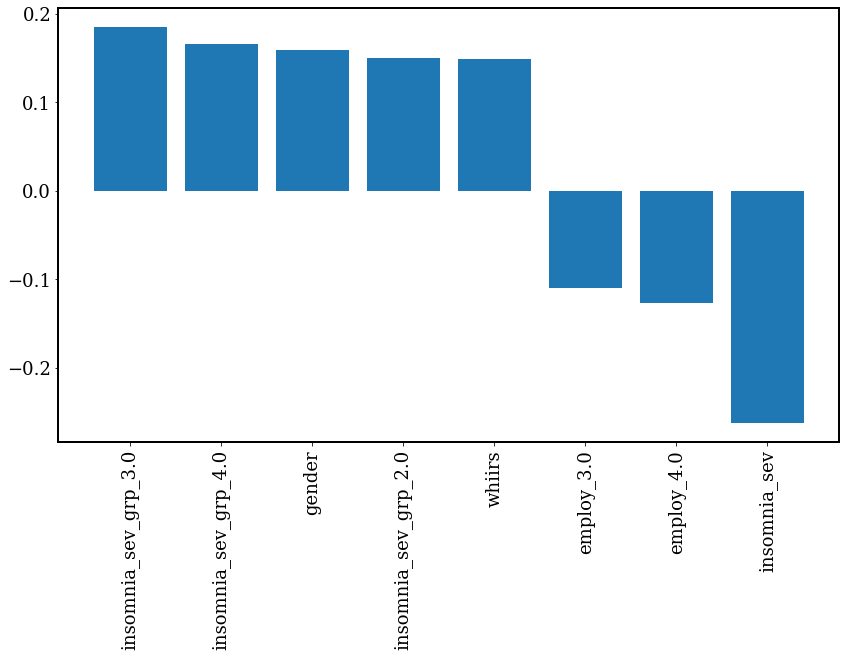

                                 OLS Regression Results                                
Dep. Variable:          TotalWakeTime   R-squared (uncentered):                   0.065
Model:                            OLS   Adj. R-squared (uncentered):              0.054
Method:                 Least Squares   F-statistic:                              6.003
Date:                Fri, 19 Jun 2020   Prob (F-statistic):                    1.80e-07
Time:                        13:57:14   Log-Likelihood:                         -973.35
No. Observations:                 701   AIC:                                      1963.
Df Residuals:                     693   BIC:                                      1999.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [21]:
#Recursive Feature Elimination 3
col4 = 'TotalWakeTime'
X_col4 = df_zipped.drop(sleep_features,axis=1)
y_col4 = df_zipped[col4]

X_train,X_test,y_train,y_test=train_test_split(X_col4,y_col4, test_size=0.3, random_state=123)

rfe4 = RFE(estimator=LinearRegression(), n_features_to_select=8, verbose=0)
model_rfe_4 = rfe4.fit(X_train, y_train)

print(X_train.columns[rfe4.support_])
print(dict(zip(X_train.columns, rfe4.ranking_)))
print(rfe4.estimator_.coef_)
print('train_score:',rfe4.score(X_train,y_train))
print('test_score:',rfe4.score(X_test,y_test))

# negate the coeff. to sort them in descending order
selected4 = pd.DataFrame(zip(X_train.columns[rfe4.support_], rfe4.estimator_.coef_))
print(selected4)
sorting4 = selected4.sort_values(1,ascending=False)
print(sorting4)

plt.bar(sorting4[0], sorting4[1])
plt.xticks(rotation=90)
plt.show()

mask4 = X_train.columns[rfe4.support_]
X_col4 = sm.add_constant(X_col4)
model_col4_sm = sm.OLS(y_train, X_train[mask4]).fit() ## sm.OLS(output, input)
predictions4 = model_col4_sm.predict(X_test[mask3])

# Print out the statistics
print(model_col4_sm.summary())